# Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/O LIVRO/Penn Treebank/Penn Treebank/Secs0-18 - training" #Ju

### Tokenization

In [ ]:
content = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)

In [ ]:
content_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_sentences.extend([pt])


### Building the Vocab

In [ ]:
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = {'<PAD>': 0}

In [ ]:
for sent in content:
    word = sent[0]
    tag = sent[1]
    word2idx.setdefault(word.lower(), len(word2idx))
    tag2idx.setdefault(tag, len(tag2idx))

In [ ]:
def index_to_tag(tag2idx):
  return {i: t for t, i in tag2idx.items()}

In [ ]:
idx2tag = index_to_tag(tag2idx)

###  Encoding sentences

In [ ]:
def encode_sentence(sentence, word2idx, tag2idx):
  words_ids = [word2idx.get(word.lower(), word2idx['<UNK>']) for word,_ in sentence]
  tags_ids = [tag2idx[tag] for _,tag in sentence]
  return words_ids, tags_ids

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in content_sentences]

### Padding

In [ ]:
import tensorflow as tf

In [ ]:
max_len = max(len(x[0]) for x in encoded_sentences)
X = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')

In [ ]:
y

array([[ 1,  1,  2, ...,  0,  0,  0],
       [ 1,  1, 12, ...,  0,  0,  0],
       [ 1,  1,  2, ...,  0,  0,  0],
       ...,
       [ 3,  1,  1, ...,  0,  0,  0],
       [ 8,  1,  1, ...,  0,  0,  0],
       [19, 12, 17, ...,  0,  0,  0]], dtype=int32)

### Convert to Tensor

In [ ]:

X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [ ]:
X

<tf.Tensor: shape=(38219, 249), dtype=int32, numpy=
array([[   2,    3,    4, ...,    0,    0,    0],
       [  19,    3,   20, ...,    0,    0,    0],
       [  28,   29,    4, ...,    0,    0,    0],
       ...,
       [ 771, 5029, 5030, ...,    0,    0,    0],
       [  10, 5029, 5030, ...,    0,    0,    0],
       [  61,   20, 1023, ...,    0,    0,    0]], dtype=int32)>

# BiLSTM

### Validation Dataset

In [ ]:
path = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
dev_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        dev_sentences.extend([pt])

In [ ]:
import numpy as np

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in dev_sentences]
max_len_development = max(len(x[0]) for x in encoded_sentences)
X_development = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = np.expand_dims(y_development, -1)

# Convertendo para tensor
X_development = tf.convert_to_tensor(X_development)
y_development = tf.convert_to_tensor(X_development)

### Model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
vocab_size = len(word2idx)
num_tags = len(tag2idx)
embedding_dim = 128  # antes era 64
rnn_units = 128      # antes era 64

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=False),
    layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(num_tags, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ajustar y para 3D: (batch, seq_len, 1)
ys = tf.expand_dims(y, -1)

history = model.fit(X, ys, epochs=30, batch_size=64, validation_data=(X_development, y_development), validation_freq=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 91s 118ms/step - accuracy: 0.9272 - loss: 0.3125
Epoch 2/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - accuracy: 0.9951 - loss: 0.0185
Epoch 3/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 70s 117ms/step - accuracy: 0.9969 - loss: 0.0103
Epoch 4/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.9975 - loss: 0.0079
Epoch 5/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 88s 129ms/step - accuracy: 0.9979 - loss: 0.0066 - val_accuracy: 0.9052 - val_loss: nan
Epoch 6/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 76s 118ms/step - accuracy: 0.9981 - loss: 0.0057
Epoch 7/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.9984 - loss: 0.0048
Epoch 8/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.9987 - loss: 0.0040
Epoch 9/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - accuracy: 0.9989 - loss: 0.0034
Epoch 10/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 84s 122ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9053 - val_loss: nan
Epoch 11/30
598/598 ━━━━━━━━━━━

In [ ]:
history.history

{'accuracy': [0.9616749286651611,
  0.9954720139503479,
  0.9969437122344971,
  0.9974344968795776,
  0.9977944493293762,
  0.9980691075325012,
  0.9983446598052979,
  0.9986037611961365,
  0.9988120198249817,
  0.9990277290344238,
  0.9991945028305054,
  0.9993612170219421,
  0.999491810798645,
  0.9995946288108826,
  0.9996904134750366,
  0.9997372031211853,
  0.9997966885566711,
  0.9998136758804321,
  0.9998206496238708,
  0.9998607039451599,
  0.9998747706413269,
  0.9998550415039062,
  0.9998661875724792,
  0.9998747706413269,
  0.9999003410339355,
  0.9999120831489563,
  0.9999086260795593,
  0.9999011754989624,
  0.9998947381973267,
  0.9999011754989624],
 'loss': [0.14875528216362,
  0.01631752960383892,
  0.009992540813982487,
  0.007978430949151516,
  0.006715978495776653,
  0.005747937597334385,
  0.004889594856649637,
  0.004163255915045738,
  0.003497306490316987,
  0.0029222730081528425,
  0.0024459538981318474,
  0.001999558648094535,
  0.0016277480171993375,
  0.001332

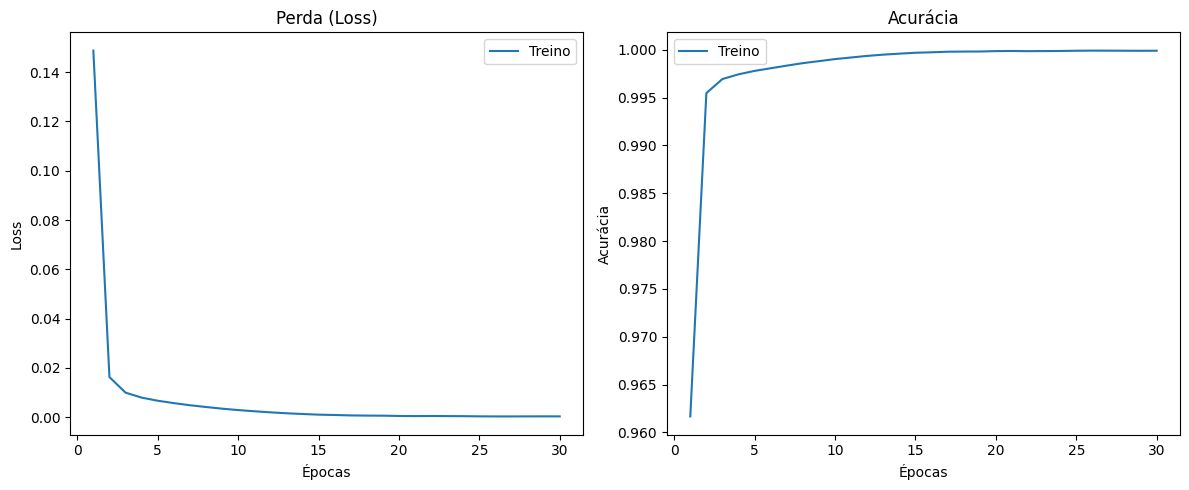

In [ ]:
import matplotlib.pyplot as plt

# Extrai os dados do histórico
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

# 📉 Perda (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Treino')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# 📊 Acurácia (accuracy), se disponível
plt.subplot(1, 2, 2)
if 'accuracy' in hist:
    plt.plot(epochs, hist['accuracy'], label='Treino')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow.keras as keras

In [ ]:
model.save("bilstm_postagger.keras")

# Load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("bilstm_postagger.keras")

In [ ]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x7e3b142373d0>

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 249, 128)       │     4,937,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 249, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 249, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 249, 46)        │        11,822 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,820,876 (64.17 MB)

 Trainable params: 5,606,958 (21.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,213,918 (42.78 MB)

## Predict

In [ ]:
path = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs22-24 - testing" #Ju

In [ ]:
sentences_test = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_test.extend(pt)

In [ ]:
sentences_dataset_spplited = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_dataset_spplited.extend([pt])

In [ ]:
import numpy as np

In [ ]:
def predict_tags(model, sentences, word2idx, idx2tag):
    # Extrair só as palavras da sentença
    words = [w for w, _ in sentences]

    # Converter as palavras para índices
    word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w in words]

    # Fazer padding
    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.int32)

    # Prever
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(words)]]

    return list(zip(words, pred_tags))


Never run the cell bellow with all the sentences_text list. Because dataset's test has about 130k data.

In [ ]:
y_true = []
y_pred = []

for sentence in sentences_dataset_spplited[:1000]:  # Cada item é uma frase: [('The', 'DT'), ('cat', 'NN'), ...]
    true_tags = [tag for _, tag in sentence]
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]

    y_true.extend(true_tags)
    y_pred.extend(predicted_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-41-4083230735.py", line 6, in <cell line: 0>
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-39-1830264742.py", line 13, in predict_tags
    pred = model.predict(padded)[0]
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 500, in predict
    epoch_iterator = TFEpochIterator(
                     ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras

TypeError: object of type 'NoneType' has no len()

In [ ]:
len(y_true)
len(y_pred)

25120

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average='macro'))


Accuracy: 0.9458996815286624
F1 macro: 0.8635096234881463


/tmp/ipython-input-44-3175798811.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


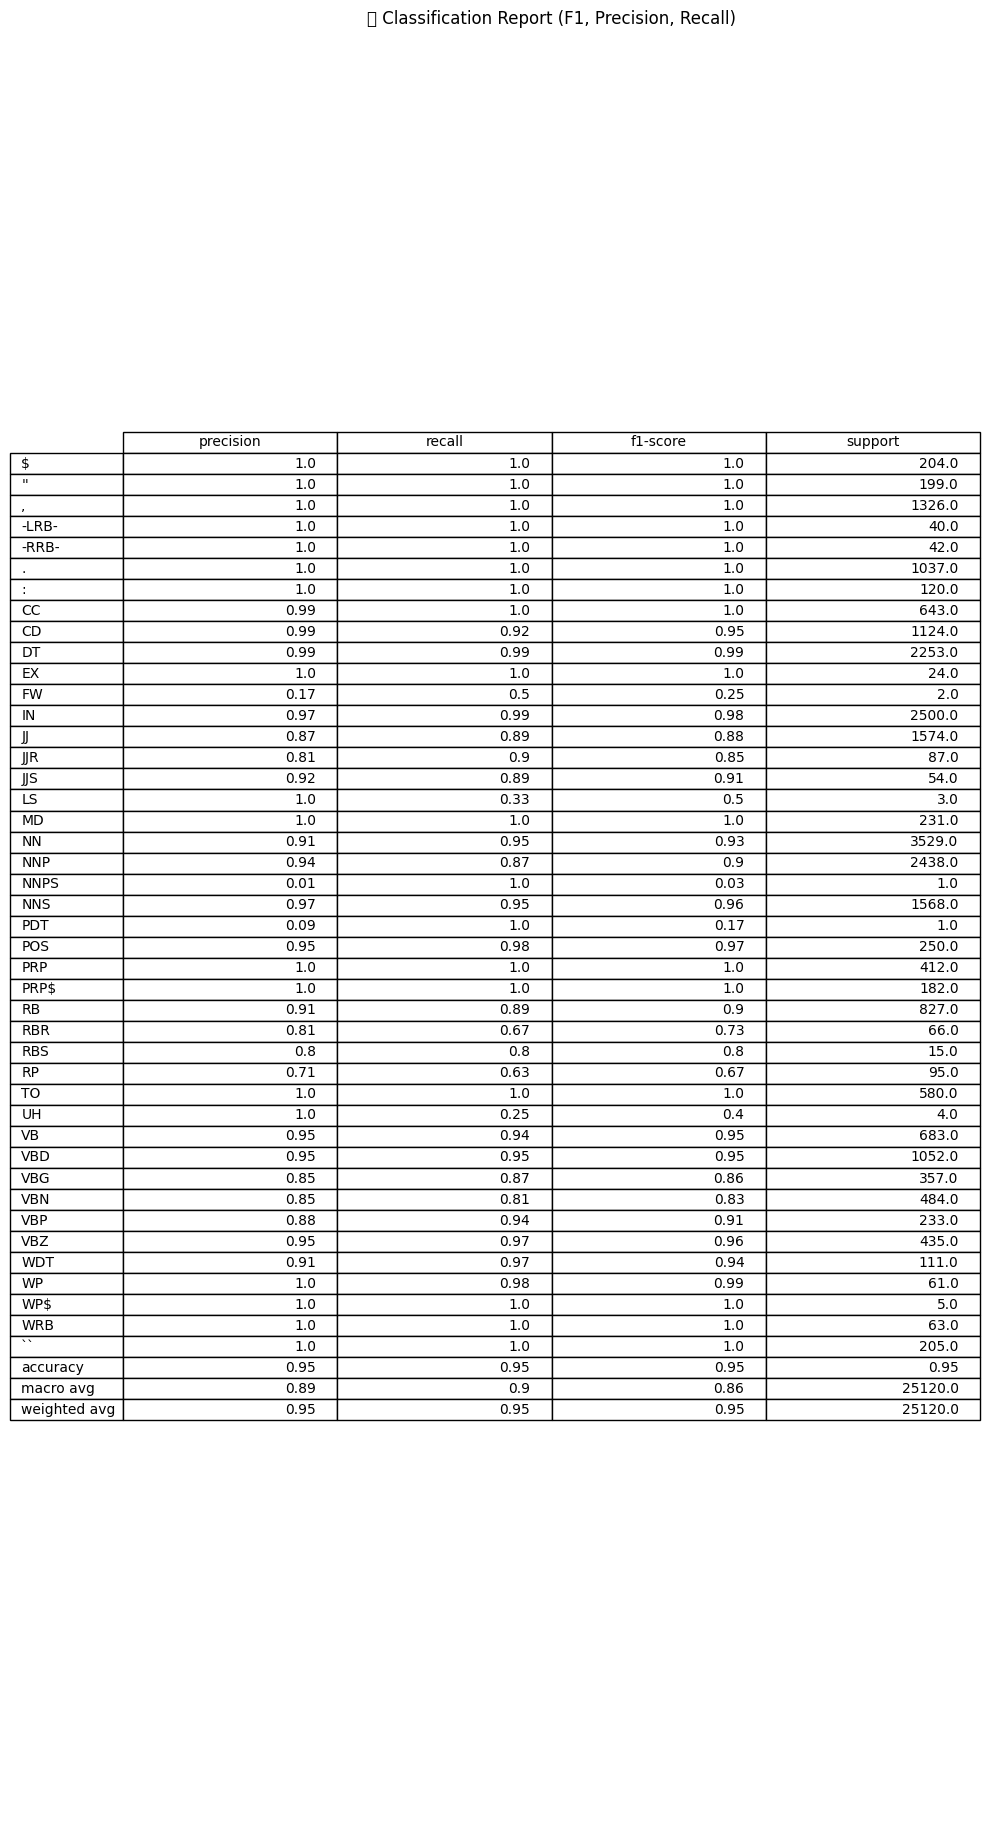

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, digits=4, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(10, len(df_report) * 0.4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.round(2).values,
         colLabels=df_report.columns,
         rowLabels=df_report.index,
         loc='center')
plt.title("📊 Classification Report (F1, Precision, Recall)")
plt.tight_layout()
plt.show()




/tmp/ipython-input-45-1207889945.py:7: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


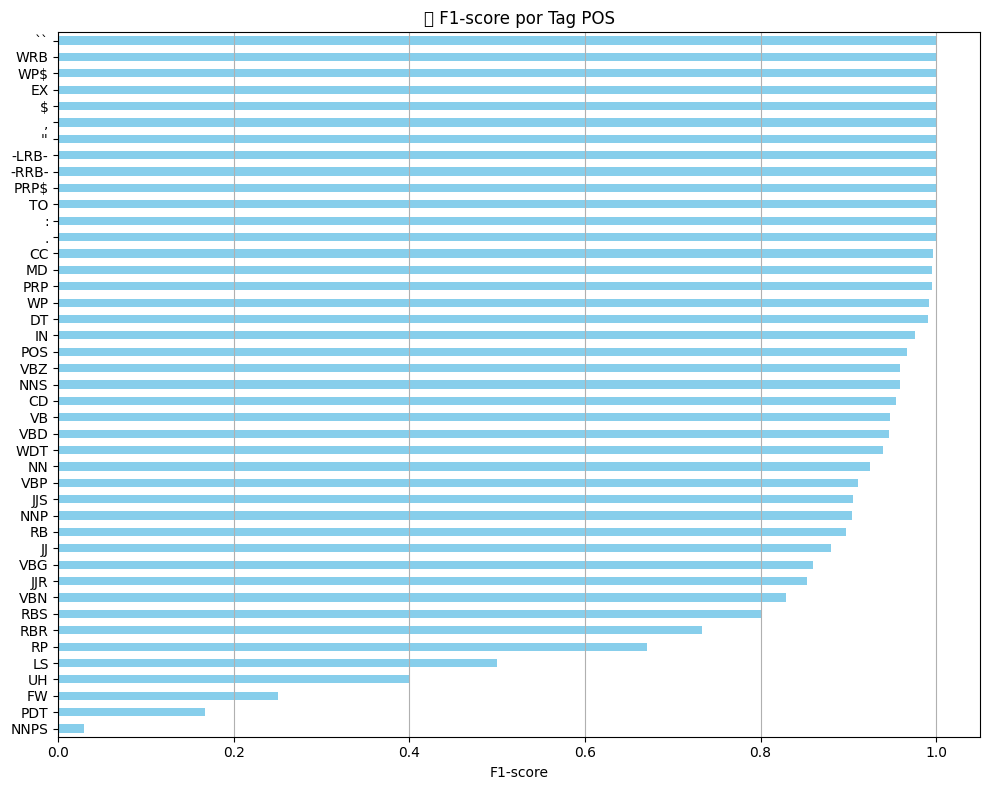

In [ ]:
f1_per_class = df_report.loc[df_report.index.str.len() <= 5].drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')['f1-score']

f1_per_class.sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("F1-score")
plt.title("📌 F1-score por Tag POS")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


/tmp/ipython-input-46-489268921.py:13: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


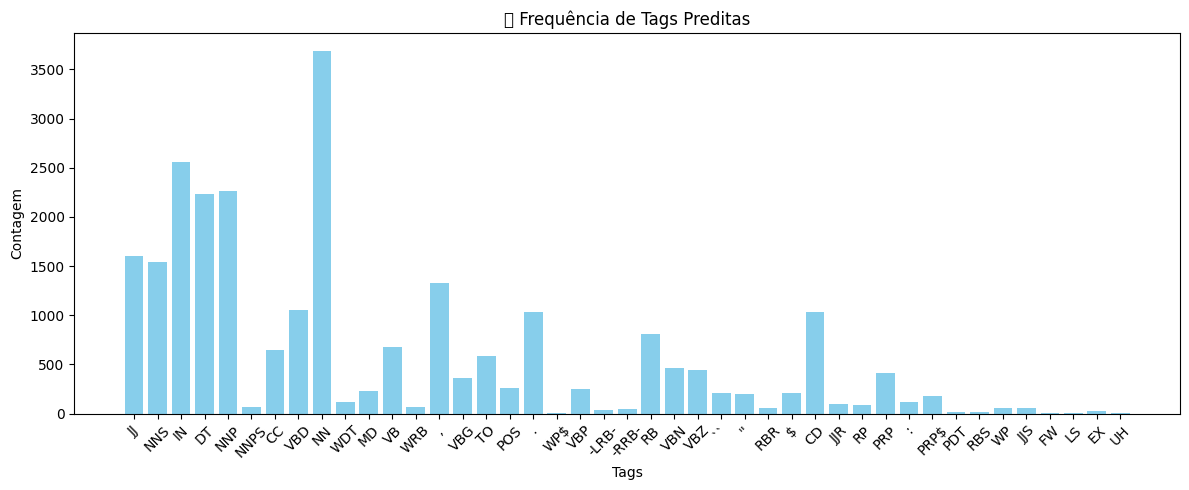

In [ ]:
from collections import Counter

# Conta as tags preditas
tag_counts = Counter(y_pred)

# Plota gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("📌 Frequência de Tags Preditas")
plt.xlabel("Tags")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-47-2512374719.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


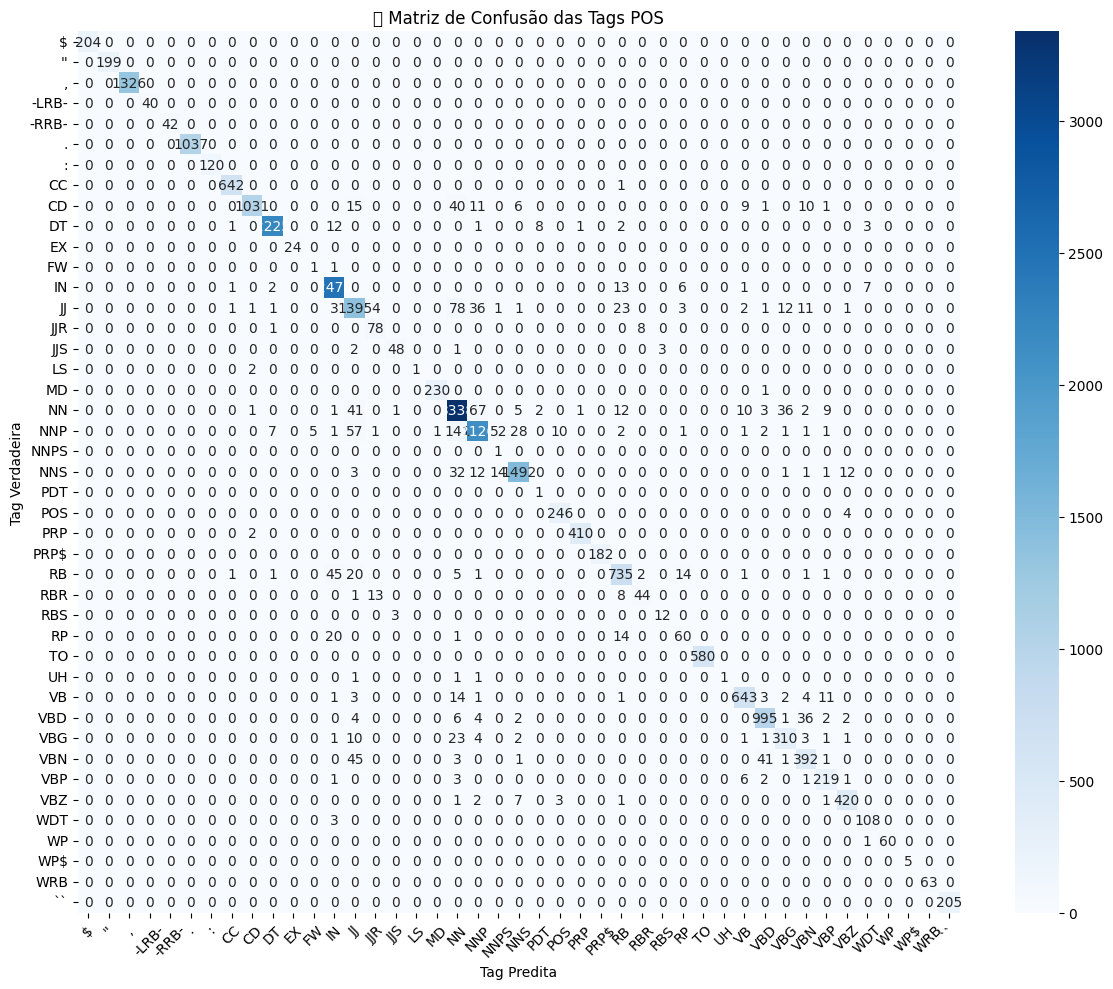

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true + y_pred)))

# Nomes das tags
labels = sorted(set(y_true + y_pred))

# Plot usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Tag Predita")
plt.ylabel("Tag Verdadeira")
plt.title("📊 Matriz de Confusão das Tags POS")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
